<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/%ED%9D%91%EB%B0%B1%EC%82%AC%EC%A7%84%EC%9D%84%20%EC%BB%AC%EB%9F%AC%EC%82%AC%EC%A7%84%EC%9C%BC%EB%A1%9C%20%EB%B0%94%EA%BE%B8%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from google.colab import drive
from IPython.display import Image

warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [3]:
pass

In [4]:
dataset_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset'
pfcn_small = np.load(dataset_path + '/pfcn_small.npz')

In [5]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

## Preprocessing

In [6]:
print(train_images.shape)
print(test_images.shape)

(1700, 100, 75, 3)
(300, 100, 75, 3)


In [7]:
(train_images[train_images != 0])

array([0.23627451, 0.34803922, 0.64705882, ..., 0.05588235, 0.0245098 ,
       0.01470588])

In [8]:
print(train_images.min(), train_images.max())
print(test_images.min(), test_images.max())

0.0 1.0
0.0 1.0


In [9]:
train_images.shape

(1700, 100, 75, 3)

In [10]:
# 흑백이미지 생성
from skimage.color import rgb2gray
train_gray_images = rgb2gray(train_images)
test_gray_images = rgb2gray(test_images)

In [11]:
print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75) (300, 100, 75)


In [12]:
train_gray_images = train_gray_images.reshape((1700,100,75,1))
test_gray_images = test_gray_images.reshape((300,100,75,1))

In [13]:
print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


## Visualizing

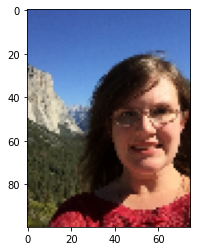

In [14]:
plt.imshow(train_images[0])

(5, 100, 75, 3)
(100, 375, 3)


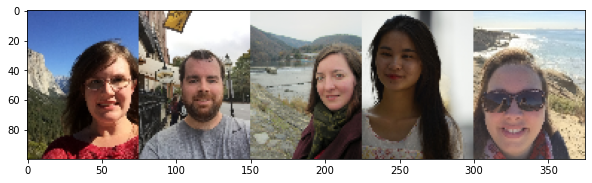

In [15]:
print(train_images[:5].shape)
print(np.hstack(train_images[:5]).shape)
plt.figure(figsize=(10,6))
plt.imshow(np.hstack(train_images[:5]))
plt.show()

(5, 100, 75, 3)
(100, 5, 75, 3)
(100, 375, 3)


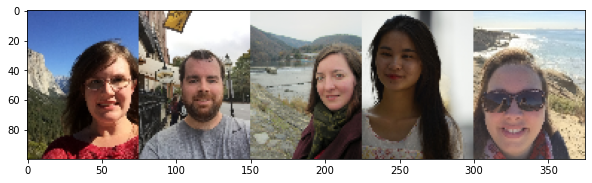

In [16]:
print(train_images[:5].shape)
print(train_images[:5].transpose(1,0,2,3).shape)
print(train_images[:5].transpose(1,0,2,3).reshape((100,-1,3)).shape)
plt.figure(figsize=(10,6))
plt.imshow(train_images[:5].transpose(1,0,2,3).reshape((100,-1,3)))
plt.show()

# Modeling

In [17]:
# Input : (100,75,1) // Output : (100,75,3)
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

In [18]:
def conv2d_block(x, channel) :
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_color() :
    inputs = Input((100,75,1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
     
    u6 = Conv2DTranspose(128, 2, 2, padding='valid', output_padding=(0,1))(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)
    
    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=(1,0))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)
    
    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=(0,1))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model


In [19]:
model = unet_color()
model.summary(
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
 model.compile(
     loss = 'mae',
     optimizer = 'adam',
     metrics=['accuracy']

 )

In [21]:
hist=model.fit(train_gray_images, train_images,
          validation_data = (test_gray_images, test_images),
          epochs = 10,
          verbose = 1)

Epoch 1/10
54/54 [==============================] - 39s 77ms/step - loss: 0.1794 - accuracy: 0.3576 - val_loss: 0.2220 - val_accuracy: 0.6739
Epoch 2/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0873 - accuracy: 0.5564 - val_loss: 0.2097 - val_accuracy: 0.6882
Epoch 3/10
54/54 [==============================] - 3s 48ms/step - loss: 0.0682 - accuracy: 0.5911 - val_loss: 0.1940 - val_accuracy: 0.6892
Epoch 4/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0622 - accuracy: 0.6213 - val_loss: 0.1843 - val_accuracy: 0.6883
Epoch 5/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0587 - accuracy: 0.6308 - val_loss: 0.1651 - val_accuracy: 0.6770
Epoch 6/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0571 - accuracy: 0.6316 - val_loss: 0.1449 - val_accuracy: 0.6541
Epoch 7/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0553 - accuracy: 0.6321 - val_loss: 0.1249 - val_accuracy: 0.6141
Epoch 8/10
5

In [22]:
# 결과 확인
res = model.predict(test_gray_images[1:2])
res.shape # test_gray_images 가 color로 바뀜

(1, 100, 75, 3)

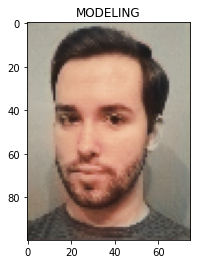

In [23]:
plt.imshow(res[0,:,:,:])
plt.title('MODELING')
plt.show()

(1, 100, 75, 3)
(100, 75, 3)
(100, 75, 3)


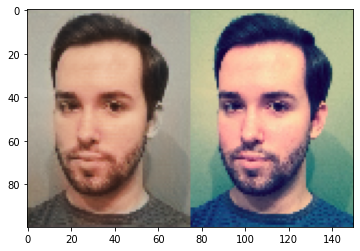

In [24]:
print(res.shape)
print(test_images[1].shape) # 두개의 사이즈를 맞춰줘야함.
print(res[0].shape)

img = np.concatenate(
    [res[0], test_images[1]],axis=1
)
plt.imshow(img)
plt.show()

In [25]:
five = model.predict(test_gray_images[:5])
five.shape

(5, 100, 75, 3)

In [26]:
test_images[:5].shape

(5, 100, 75, 3)

In [27]:
imgs = np.concatenate(
    [five , test_images[:5]],axis=1
)
imgs.shape

(5, 200, 75, 3)

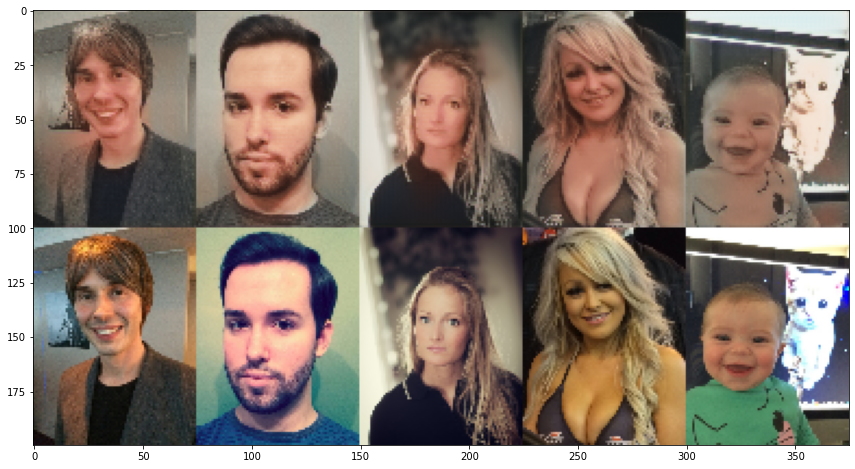

In [28]:
plt.figure(figsize=(15,8))
plt.imshow(imgs.transpose((1,0,2,3)).reshape((200,-1,3)))
plt.show()

# lab color modeling

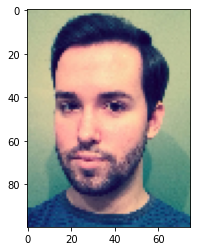

In [29]:
# rgb -> lab color
plt.imshow(test_images[1])
plt.show()

In [30]:
from skimage.color import rgb2lab
print(f'rgb -> lab color로 변환 시 shape : {rgb2lab(test_images[1]).shape}' )

rgb -> lab color로 변환 시 shape : (100, 75, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


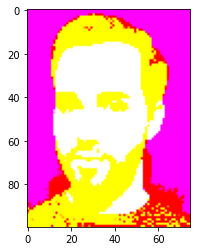

In [31]:
plt.imshow(rgb2lab(test_images[1]))
plt.show()

In [32]:
train_lab_images  = np.array(
    [rgb2lab(img) for img in train_images]
)
test_lab_images  = np.array(
    [rgb2lab(img) for img in test_images]
)

In [33]:
print(f'train_lab_images shape : {train_lab_images.shape}')
print(f'test_lab_images shape : {test_lab_images.shape}')

train_lab_images shape : (1700, 100, 75, 3)
test_lab_images shape : (300, 100, 75, 3)


In [34]:
# lab color의 범위를 봐보자
print(train_lab_images[train_lab_images!=0])
print(train_lab_images.max(), train_lab_images.min())

[ 39.21947459  14.33385219 -44.39105474 ...   2.16147545   1.88280133
   1.7321822 ]
100.0 -91.97308466277427


In [35]:
# 채널별로 확인해보자
print('0번 채널 범위 : ', train_lab_images[...,0].min(),'~',train_lab_images[...,0].max()) # 0번채널
print('1번 채널 범위 : ', train_lab_images[...,1].min(),'~',train_lab_images[...,1].max()) # 1번채널
print('2번 채널 범위 : ',train_lab_images[...,2].min(),'~',train_lab_images[...,2].max()) # 2번채널

0번 채널 범위 :  0.0 ~ 100.0
1번 채널 범위 :  -78.53736435567544 ~ 86.20773183914271
2번 채널 범위 :  -91.97308466277427 ~ 93.80664030542576


In [36]:
# 0-1 Normalize
# BroadCasting 활용하기
# 0번 채널의 범위 : [0,100]
# 1번 채널의 범위 : [-78.53736435567544, 86.20773183914271]
# 2번 채널의 범위 : [-91.97308466277427, 93.80664030542576]
tempt = train_lab_images - [train_lab_images[...,0].min(), train_lab_images[...,1].min(), train_lab_images[...,2].min()] # 최솟값을 빼줘서 0으로 맞춰줌
print('0번 채널 범위 : ', tempt[...,0].min(),'~',tempt[...,0].max()) # 0번채널
print('1번 채널 범위 : ', tempt[...,1].min(),'~',tempt[...,1].max()) # 1번채널
print('2번 채널 범위 : ',tempt[...,2].min(),'~',tempt[...,2].max()) # 2번채널

# 그 후 최댓값으로 나눠준다.
print('---------------------------')
tempt2 = tempt / [tempt[...,0].max(), tempt[...,1].max(), tempt[...,2].max()]
print('0번 채널 범위 : ', tempt2[...,0].min(),'~',tempt2[...,0].max()) # 0번채널
print('1번 채널 범위 : ', tempt2[...,1].min(),'~',tempt2[...,1].max()) # 1번채널
print('2번 채널 범위 : ',tempt2[...,2].min(),'~',tempt2[...,2].max()) # 2번채널

0번 채널 범위 :  0.0 ~ 100.0
1번 채널 범위 :  0.0 ~ 164.74509619481813
2번 채널 범위 :  0.0 ~ 185.77972496820001
---------------------------
0번 채널 범위 :  0.0 ~ 1.0
1번 채널 범위 :  0.0 ~ 1.0
2번 채널 범위 :  0.0 ~ 1.0


In [37]:
train_temp = train_lab_images - [train_lab_images[...,0].min(), 
                                 train_lab_images[...,1].min(),
                                 train_lab_images[...,2].min()]
train_lab_images = train_temp / [train_temp[...,0].max(),
                                 train_temp[...,1].max(),
                                 train_temp[...,2].max()]


In [38]:
print('0번 채널 범위 : ', train_lab_images[...,0].min(),'~',train_lab_images[...,0].max()) # 0번채널
print('1번 채널 범위 : ', train_lab_images[...,1].min(),'~',train_lab_images[...,1].max()) # 1번채널
print('2번 채널 범위 : ',train_lab_images[...,2].min(),'~',train_lab_images[...,2].max()) # 2번채널

0번 채널 범위 :  0.0 ~ 1.0
1번 채널 범위 :  0.0 ~ 1.0
2번 채널 범위 :  0.0 ~ 1.0


In [39]:
test_temp = test_lab_images - [test_lab_images[...,0].min(), 
                               test_lab_images[...,1].min(),
                               test_lab_images[...,2].min()]
test_lab_images = test_temp / [test_temp[...,0].max(),
                               test_temp[...,1].max(),
                               test_temp[...,2].max()]
print('0번 채널 범위 : ', test_lab_images[...,0].min(),'~',test_lab_images[...,0].max()) # 0번채널
print('1번 채널 범위 : ', test_lab_images[...,1].min(),'~',test_lab_images[...,1].max()) # 1번채널
print('2번 채널 범위 : ', test_lab_images[...,2].min(),'~',test_lab_images[...,2].max()) # 2번채널

0번 채널 범위 :  0.0 ~ 1.0
1번 채널 범위 :  0.0 ~ 1.0
2번 채널 범위 :  0.0 ~ 1.0


In [40]:
# 이미지 하나의 첫 번째 채널을 plt로 출력
print(train_lab_images[1].shape)
print(train_lab_images[1][...,0].shape) # train_lab_images[1][0] 이 아님 !!

(100, 75, 3)
(100, 75)


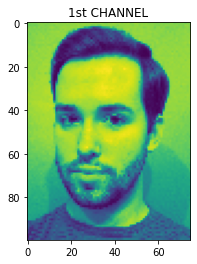

In [41]:
plt.imshow(test_lab_images[1][...,0]) # 첫번째 채널을 출력하는 것임. 여기서 채널은 rgb 같은 것 (RGB는 아님)
plt.title('1st CHANNEL')
plt.show()

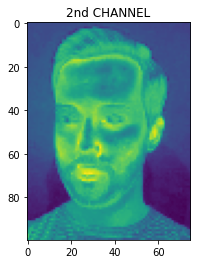

In [42]:
plt.imshow(test_lab_images[1][...,1])  # 2번째 채널
plt.title('2nd CHANNEL')
plt.show()

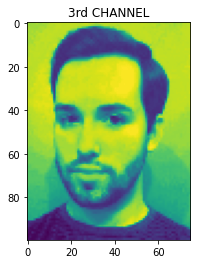

In [43]:
plt.imshow(test_lab_images[1][...,2])
plt.title('3rd CHANNEL')
plt.show()

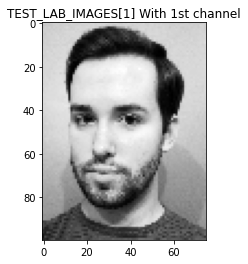

In [44]:
plt.imshow(test_lab_images[1][...,0], cmap='gray')
plt.title('TEST_LAB_IMAGES[1] With 1st channel')
plt.show()

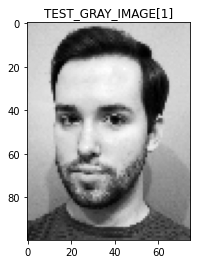

In [45]:
plt.imshow(test_gray_images[1][...,0], cmap='gray')
plt.title('TEST_GRAY_IMAGE[1]')
plt.show()

In [46]:
# model
def unet_lab() :
    inputs = Input((100,75,1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
     
    u6 = Conv2DTranspose(128, 2, 2, padding='valid', output_padding=(0,1))(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)
    
    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=(1,0))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)
    
    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=(0,1))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation='sigmoid')(c9) #output : 2 
    
    model = Model(inputs, outputs)
    return model

In [47]:
model2 = unet_lab()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 100, 75, 16)  160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 100, 75, 16)  64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 100, 75, 16)  0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [48]:
model2.compile(
    loss = 'mae',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [49]:
# input : 약간 흑백이미지(1st channel), output : (2nd & 3rd channel)
hist2 = model2.fit(
    train_lab_images[...,0:1], train_lab_images[...,1:],
    validation_data = (test_lab_images[...,0:1], test_lab_images[...,1:]),
    epochs = 10,
    verbose = 1
)

Epoch 1/10
54/54 [==============================] - 5s 60ms/step - loss: 0.0885 - accuracy: 0.6401 - val_loss: 0.0592 - val_accuracy: 0.9012
Epoch 2/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0521 - accuracy: 0.6942 - val_loss: 0.0549 - val_accuracy: 0.9012
Epoch 3/10
54/54 [==============================] - 3s 48ms/step - loss: 0.0492 - accuracy: 0.6977 - val_loss: 0.0613 - val_accuracy: 0.7831
Epoch 4/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0468 - accuracy: 0.6992 - val_loss: 0.0591 - val_accuracy: 0.9008
Epoch 5/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0477 - accuracy: 0.6963 - val_loss: 0.0558 - val_accuracy: 0.9012
Epoch 6/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0461 - accuracy: 0.7067 - val_loss: 0.0535 - val_accuracy: 0.9004
Epoch 7/10
54/54 [==============================] - 3s 49ms/step - loss: 0.0466 - accuracy: 0.6938 - val_loss: 0.0558 - val_accuracy: 0.9012
Epoch 8/10
54

In [50]:
# RESULT
res2 = model2.predict(test_lab_images[1:2][...,0:1])
res2.shape

(1, 100, 75, 2)